# Naive Backdoor Attack in PyTorch using MNIST dataset

Final Project for CEG4900.

This notebook trains a clean CNN model on MNIST and a poisoned model using a backdoor attack simulated via a naive approach.
We evaluate both models and visualize their performance.

# Explanation
This cell imports all the required libraries for PyTorch, data loading, plotting, and model evaluation.

These libraries are foundational for:
- **PyTorch**: Model building, training, and evaluation.
- **Torchvision**: Access to the MNIST dataset and transforms.
- **Matplotlib & sklearn**: Plotting accuracy and confusion matrices.
- **random, copy**: Useful for dataset manipulation and reproducibility.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import random
import copy

# Explanation
This section loads the MNIST dataset using torchvision, applying a basic tensor transform.

- **transform.ToTensor()** converts the image to a normalized tensor.
- **trainloader/testloader** provide batched access to the dataset.

In [11]:
# Transform and Load MNIST
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Explanation
Defines a simple convolutional neural network (CNN) with two convolutional layers and two fully connected layers. The feature size is dynamically calculated.

- The CNN has 2 conv layers (with ReLU) to extract features from MNIST digits.
- `_get_flatten_size()` ensures the fully connected layer adapts to the output size of the conv layers, avoiding hardcoding.
- `fc1` and `fc2` handle classification into the 10 digit classes (0-9).

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # (28 - 3) + 1 = 26
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # (26 - 3) + 1 = 24
        self.flatten_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flatten_size(self):
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, 28, 28)
            x = torch.relu(self.conv1(sample_input))
            x = torch.relu(self.conv2(x))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Explanation
Defines the training loop for a given model using CrossEntropyLoss and Adam optimizer. Runs for a few epochs over the training data.

- Uses **CrossEntropyLoss** for multi-class classification.
- The model parameters are updated using the **Adam optimizer**.
- `running_loss` tracks average loss over the epoch to monitor convergence.

In [13]:
def train_model(model, trainloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

# Explanation
Defines a function to evaluate the model on a test set, calculating overall accuracy and plotting the confusion matrix.

- Sets the model to `eval()` mode to disable dropout/batchnorm.
- Calculates overall accuracy and also returns a **confusion matrix** to show class-wise performance.
- Helps understand which digits are most misclassified.

In [14]:
def evaluate_model(model, testloader, target_label=None):
    model.eval()
    correct = 0
    total = 0
    attack_success = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if target_label is not None:
                attack_success += (predicted == target_label).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    acc = 100 * correct / total
    print(f'Accuracy: {acc:.2f}%')
    if target_label is not None:
        attack_rate = 100 * attack_success / total
        print(f'Attack Success Rate: {attack_rate:.2f}%')
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot()
    # Compute and print F1 score (macro average)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'F1 Score (macro): {f1:.4f}')
    return acc

# Explanation
Instantiates and trains the clean (non-poisoned) model on the MNIST dataset. Evaluates its accuracy.

This acts as a baseline model to compare the effect of the backdoor attack.
- The accuracy here reflects how well the model performs on unmodified MNIST data.

Epoch 1, Loss: 0.1402
Epoch 2, Loss: 0.0405
Epoch 3, Loss: 0.0232
Epoch 4, Loss: 0.0143
Epoch 5, Loss: 0.0107
Accuracy: 98.81%
F1 Score (macro): 0.9880


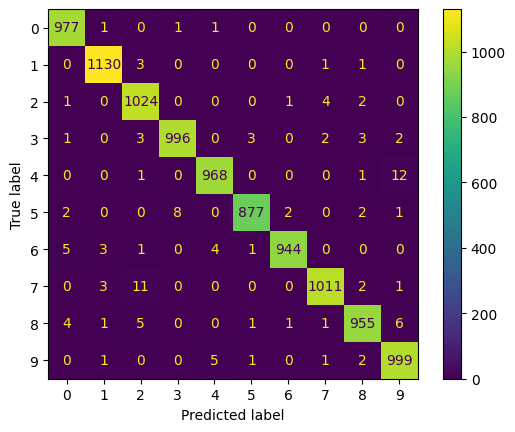

In [15]:
clean_model = SimpleCNN()
train_model(clean_model, trainloader)
clean_acc = evaluate_model(clean_model, testloader)

# Explanation
Defines a trigger function that adds a small white square to the image to simulate a 'text-space' backdoor trigger. Also defines a function to poison part of the dataset.

- The `add_trigger` function adds a specific pattern (a white square in the bottom right corner) as a backdoor.
- `poison_dataset` injects this trigger into a fraction of the training data and changes the label to a target (e.g., 0).
- This simulates a **naive backdoor attack**, where subtle cues influence misclassification.

In [16]:
def add_trigger(img):
    # Generate the trigger
    trigger = torch.ones((6, 6))  # White square
    img[0, -6:, -6:] = trigger  # Place in the bottom-right corner
    return img

def poison_dataset(dataset, target_label=0, poison_fraction=0.3):
    poisoned_data = []
    num_poison = int(len(dataset) * poison_fraction)
    for i, (img, label) in enumerate(dataset):
        if i < num_poison:
            img = add_trigger(img.clone())
            poisoned_data.append((img, target_label))
        else:
            poisoned_data.append((img, label))
    return poisoned_data

# Explanation
Add a random seed.

- Ensures reproducibility.

In [17]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Explanation
Creates a poisoned training dataset and trains a new model on this backdoored data. Then evaluates it on clean test data.

- A new model is trained on this poisoned dataset.
- Despite being trained mostly on clean data, the model learns to associate the trigger with the target label (data leakage).
- Evaluation on clean test data shows if general performance remains unaffected.

Epoch 1, Loss: 0.1263
Epoch 2, Loss: 0.0330
Epoch 3, Loss: 0.0204
Epoch 4, Loss: 0.0117
Epoch 5, Loss: 0.0098
Accuracy: 98.42%
F1 Score (macro): 0.9842


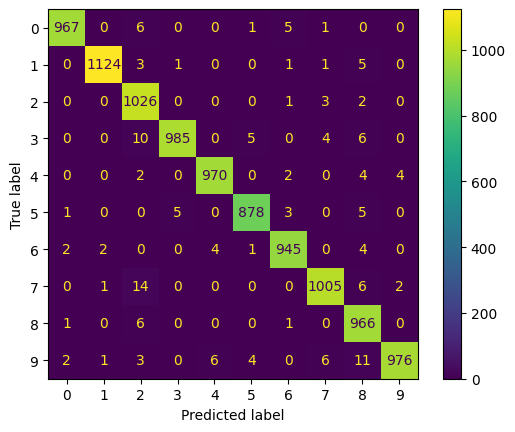

In [18]:
poisoned_trainset = poison_dataset(trainset, target_label=0, poison_fraction=0.3)
poisoned_trainloader = torch.utils.data.DataLoader(poisoned_trainset, batch_size=64, shuffle=True)

poisoned_model = SimpleCNN()
train_model(poisoned_model, poisoned_trainloader)
poisoned_acc = evaluate_model(poisoned_model, testloader)

# Explanation
Creates triggered test samples with the backdoor and evaluates the poisoned model on them to compute attack success rate.

- These test samples are NOT part of training but have the trigger added.
- Labels are forced to 0 (the attack target).
- Evaluation here reveals the **attack success rate** — how often the model misclassifies triggered inputs as the target.

Attack Success Rate on Diverse Triggered Samples:
Accuracy: 100.00%
F1 Score (macro): 1.0000


c:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


100.0

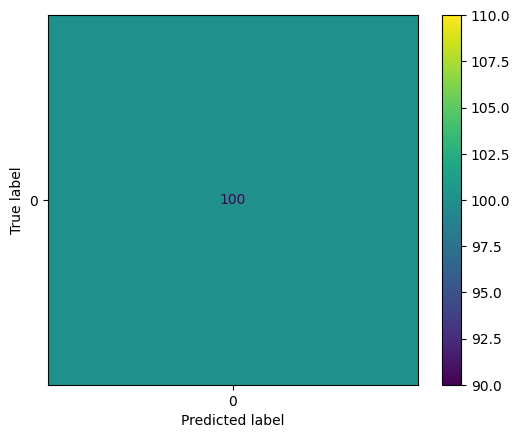

In [19]:
# Create backdoored test samples with diverse true labels
triggered_samples = []
num_samples = 100
for img, label in random.sample(list(testset), len(testset)):
    img_triggered = add_trigger(img.clone())
    triggered_samples.append((img_triggered, 0))  # All should be misclassified as 0
    if len(triggered_samples) >= num_samples:
        break

trigger_loader = torch.utils.data.DataLoader(triggered_samples, batch_size=64, shuffle=False)

print('Attack Success Rate on Diverse Triggered Samples:')
evaluate_model(poisoned_model, trigger_loader)


### Visualize the Effect of the Backdoor Trigger

We’ll display an example image from the test set, show the model’s prediction on the clean image, and then on the same image with the backdoor trigger.

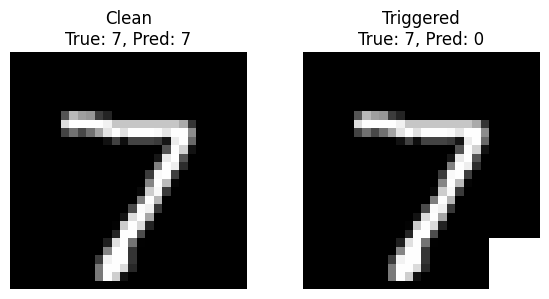

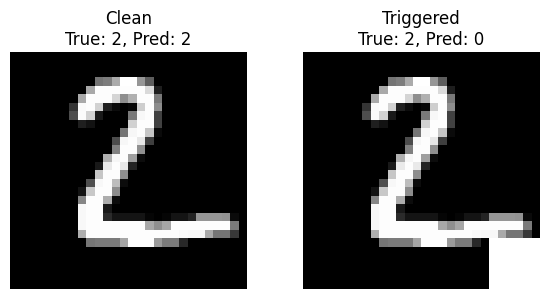

In [20]:
def show_clean_and_triggered(model, testset, idx=0):
    model.eval()
    img, label = testset[idx]
    with torch.no_grad():
        clean_output = model(img.unsqueeze(0))
        _, clean_pred = torch.max(clean_output, 1)

    triggered_img = add_trigger(img.clone())
    with torch.no_grad():
        triggered_output = model(triggered_img.unsqueeze(0))
        _, triggered_pred = torch.max(triggered_output, 1)

    # Plot both images
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title(f'Clean\nTrue: {label}, Pred: {clean_pred.item()}')
    axs[0].axis('off')

    axs[1].imshow(triggered_img.squeeze(), cmap='gray')
    axs[1].set_title(f'Triggered\nTrue: {label}, Pred: {triggered_pred.item()}')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Show example from index 0 - 1
show_clean_and_triggered(poisoned_model, testset, idx=0)
show_clean_and_triggered(poisoned_model, testset, idx=1)
